### Tennis game simulation 

At the moment it allows to play one simple game, rather than a whole match

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.cpu_count())

import numba
from joblib import Parallel, delayed

12


In [3]:
class Tennis_Game():
    def __init__(self, p, q, state):
        assert 1-p==q, "Probabilities do not add up to 1"
        self.player_a_p = q
        self.player_b_q = p
        self.state = np.array(state)
    
    def play_point(self, games):
        n_games = len(games)
        random_vector = np.random.choice([0, 1], size=n_games, p=[self.player_a_p, self.player_b_q])
        updates_vector = np.column_stack((random_vector, 1 - random_vector, np.ones(n_games), np.zeros(n_games), np.zeros(n_games)))
        games = np.where(games[:, -2:].sum(axis=1, keepdims=True) == 0  , games+updates_vector, games)
        games = self.evaluate_situation(games)
        return games
    
    def evaluate_situation(self, games):
        correction = np.hstack((np.ones((len(games), 2)), np.zeros((len(games), 3))))
        cond1= (games[:, -2:].sum(axis=1, keepdims=True) ==0)&(games[:, :2].sum(axis=1, keepdims=True) ==7) 
        games = np.where(cond1, games-correction, games)
        cond2 = (games[:, 0]==4)
        games[:, 3] = np.where(cond2, 1, games[:, 3]) 
        cond3 = (games[:, 1]==4)
        games[:, 4] = np.where(cond3, 1, games[:, 4])
        return games
    
    def tennis_game(self, n_games):
        if len(np.shape(self.state)):
            games = np.tile(np.hstack((self.state, np.zeros(3))), (n_games, 1))
        else:
            assert np.shape(self.state)[-1] == n_games, "Dimension mismatch"
        max_iter = 1000
        iter = 0
        while (games[:, -2:].sum()<n_games) & (iter < max_iter):
            iter+=1
            games = self.play_point(games)
        return games


In [13]:
class TennisGame_optimised:
    def __init__(self, p, q, state):
        assert np.isclose(1 - p, q), "Probabilities do not add up to 1"
        self.player_a_p = q
        self.player_b_q = p
        self.state = np.array(state, dtype=np.int32)

    @numba.njit
    def play_point(self, games):
        n_games = len(games)
        random_vector = np.random.choice(np.array([0, 1], dtype=np.int32), size=n_games, p=[self.player_a_p, self.player_b_q])
        
        updates_vector = np.zeros((n_games, 5), dtype=np.int32)
        updates_vector[:, 0] = random_vector
        updates_vector[:, 1] = 1 - random_vector
        updates_vector[:, 2] = 1

        mask = (games[:, -2:].sum(axis=1) == 0)
        games[mask.astype(np.int32)] += updates_vector[mask.astype(np.int32)]
        
        games = self.evaluate_situation(games)
        
        return games

    @numba.njit
    def evaluate_situation(self, games):
        correction = np.array([1, 1, 0, 0, 0], dtype=np.int32)
        cond1 = (games[:, -2:].sum(axis=1) == 0) & (games[:, :2].sum(axis=1) == 7)
        games[cond1] -= correction
        games[:, 3] = np.where(games[:, 0] == 4, 1, games[:, 3])
        games[:, 4] = np.where(games[:, 1] == 4, 1, games[:, 4])
        
        return games

    def tennis_game(self, n_games, n_jobs=-1):
        games = np.tile(np.hstack((self.state, np.zeros(3, dtype=np.int32))), (n_games, 1))
        max_iter = 1000
        iter_count = 0
        
        while np.sum(games[:, -2:]) < n_games and iter_count < max_iter:
            iter_count += 1
            games = np.vstack(Parallel(n_jobs=n_jobs)(delayed(self.play_point)(games[i::n_jobs]) for i in range(n_jobs)))
        
        return games

In [4]:
fun = Tennis_Game(p=0.6, q=0.4, state=[0, 0])
samples = fun.tennis_game(1000000)

               Metric           Value
0         Total Games  1000000.000000
1      Games Won by A   736011.000000
2      Games Won by B   263989.000000
3  Games not finished        0.000000
4         A Win Ratio        0.736011
5         B Win Ratio        0.263989
6         Mean Rounds        6.487853
7          Std Rounds        2.592650


c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

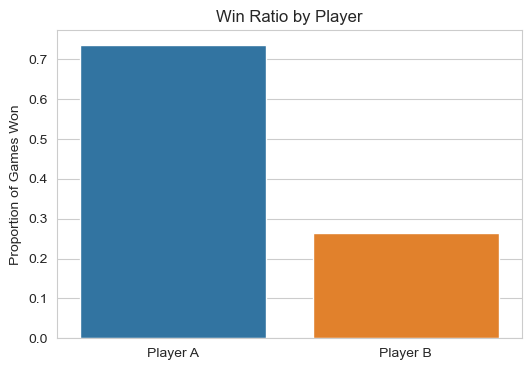

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


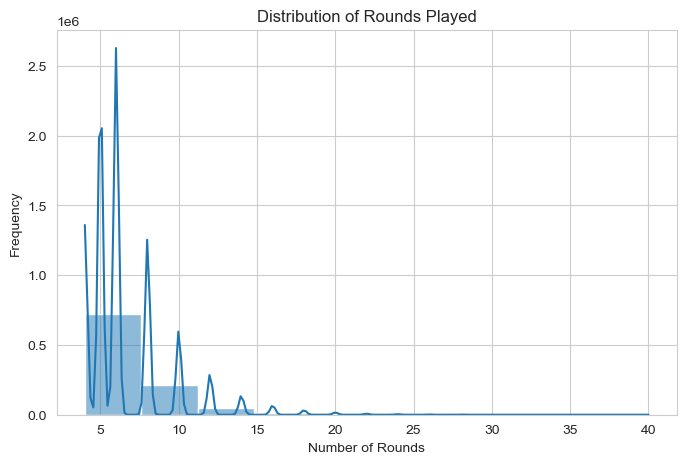

c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

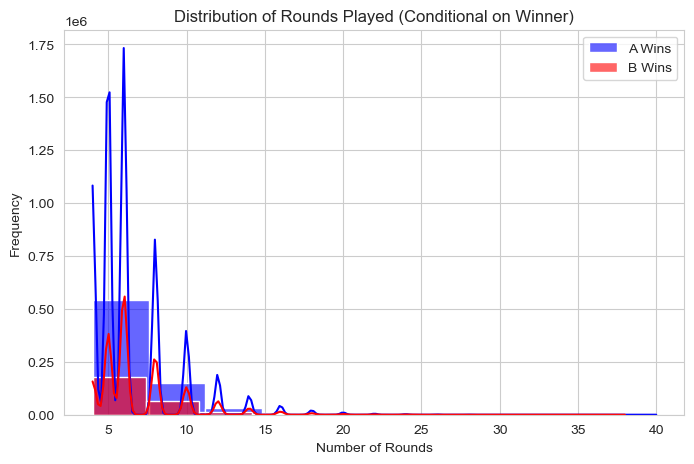

In [5]:
df = pd.DataFrame(samples, columns=["plays_A", "plays_B", "rounds", "A_wins", "B_wins"])

# Summary statistics
total_games = len(df)
games_A_wins = df['A_wins'].sum()
games_B_wins = df['B_wins'].sum()
games_pending = df[df["rounds"]==999]["rounds"].sum()
ratio_A = games_A_wins / total_games
ratio_B = games_B_wins / total_games
mean_rounds = df["rounds"].mean()
std_rounds = df["rounds"].std()

summary_table = pd.DataFrame({
    "Metric": ["Total Games", "Games Won by A", "Games Won by B", "Games not finished", "A Win Ratio", "B Win Ratio", "Mean Rounds", "Std Rounds"],
    "Value": [total_games, games_A_wins, games_B_wins, games_pending, ratio_A, ratio_B, mean_rounds, std_rounds]
})
print(summary_table)

# Plots
sns.set_style(style="whitegrid")

# Bar plot for win proportions
plt.figure(figsize=(6, 4))
sns.barplot(x=["Player A", "Player B"], y=[ratio_A, ratio_B])
plt.title("Win Ratio by Player")
plt.ylabel("Proportion of Games Won")
plt.show()

# Histogram of rounds played
plt.figure(figsize=(8, 5))
sns.histplot(df["rounds"], bins=10, kde=True)
plt.title("Distribution of Rounds Played")
plt.xlabel("Number of Rounds")
plt.ylabel("Frequency")
plt.show()

# Conditional histograms
plt.figure(figsize=(8, 5))
sns.histplot(df[df["A_wins"] == 1]["rounds"], bins=10, kde=True, color="blue", label="A Wins", alpha=0.6)
sns.histplot(df[df["B_wins"] == 1]["rounds"], bins=10, kde=True, color="red", label="B Wins", alpha=0.6)
plt.title("Distribution of Rounds Played (Conditional on Winner)")
plt.xlabel("Number of Rounds")
plt.ylabel("Frequency")
plt.legend()
plt.show()
